# Ultrasonic Signal Simulation

This code simulates the burst signal for an ultrasonic sensor. 

In [1]:
import numpy as np      # Library for Math
import matplotlib.pyplot as plt  # library for plotting
from scipy.fft import rfft, rfftfreq

# Parameters
num_bursts = 5             # Number of bursts to simulate
burst_spacing = 0.002      # Spacing between bursts (seconds), e.g., 2 ms
num_pulses = 15           # total pulses in the burst
frequency = 40_000           # typical ultrasonic frequency in Hz (40 kHz)
sampling_rate = 1_000_000 # samples per second
cycles_per_pulse = 1      # how many sine cycles per pulse (for shape control)

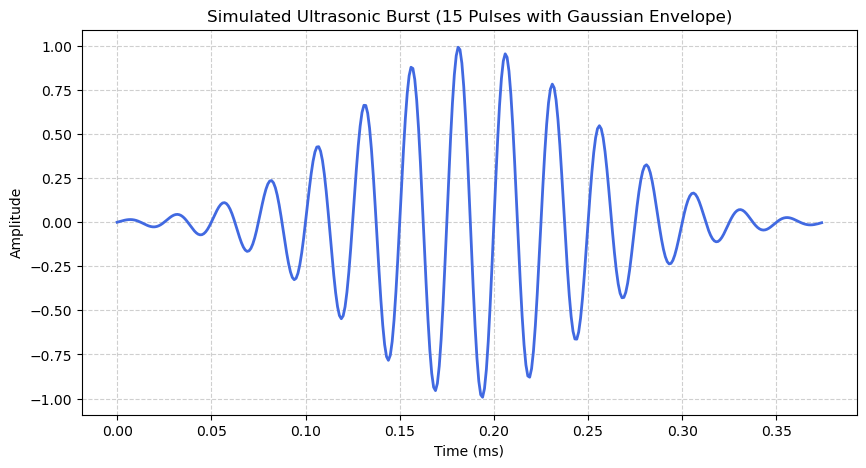

In [2]:
# Time vector for the whole burst
# The time array is needed to define at what time each sample occurs
# This lasts for the duration of 15 pulses
t_pulse = np.arange(0, num_pulses / frequency, 1 / sampling_rate)

# Generate the sine wave
signal = np.sin(2 * np.pi * frequency * t_pulse)

# Create a Gaussian envelope (so middle pulses are strongest)
center = len(t_pulse) / 2   # centre is the middle of the time array where the burst is to be strongest
sigma = len(t_pulse) / 6    # sigma controls how wide the envelope curve is (how quickly it fades away)
envelope = np.exp(-0.5 * ((np.arange(len(t_pulse)) - center) / sigma) ** 2)

# Modulate the sine wave with the envelope
burst = signal * envelope

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_pulse * 1e3, burst, color='royalblue', linewidth=2)
plt.title("Simulated Ultrasonic Burst (15 Pulses with Gaussian Envelope)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Simulation of reflected signal

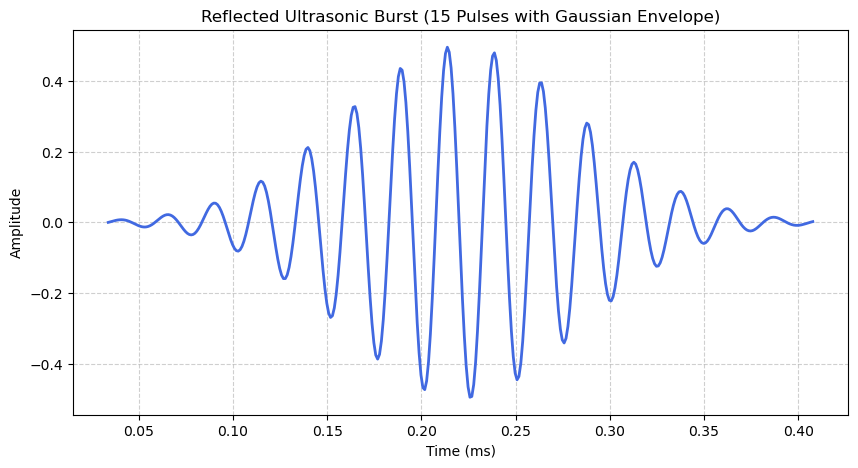

In [3]:
# Relfection Parameters
speed_of_sound = 1480     # Speed of sound in Water (m/s)
distance = 0.025          # Distance to reflector (meter), example : 25 mm
velocity_reflector = 10   # Reflector velocity toward sensor (m/s)
attenuation_factor = 0.5  # Amplitude reduction of the echo

# Calculate the time delay for the echo (two-way travel time)
time_delay = 2 * distance / speed_of_sound

# Calculate the Doppler-shifted frequency for the reflection
doppler_frequency = frequency * (speed_of_sound + velocity_reflector) / speed_of_sound

# Generate time vector for reflected signal, shifted by the delay
t_reflected = t_pulse + time_delay

# Generate the Doppler-shifted burst for the reflected signal
reflected_signal = np.sin( 2 * np.pi * doppler_frequency * (t_reflected - time_delay))
reflected_envelope = np.exp(-0.5 * ((np.arange(len(t_reflected)) - center) / sigma) ** 2)
reflected_burst = attenuation_factor * reflected_signal * reflected_envelope

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_reflected * 1e3, reflected_burst, color='royalblue', linewidth=2)
plt.title("Reflected Ultrasonic Burst (15 Pulses with Gaussian Envelope)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

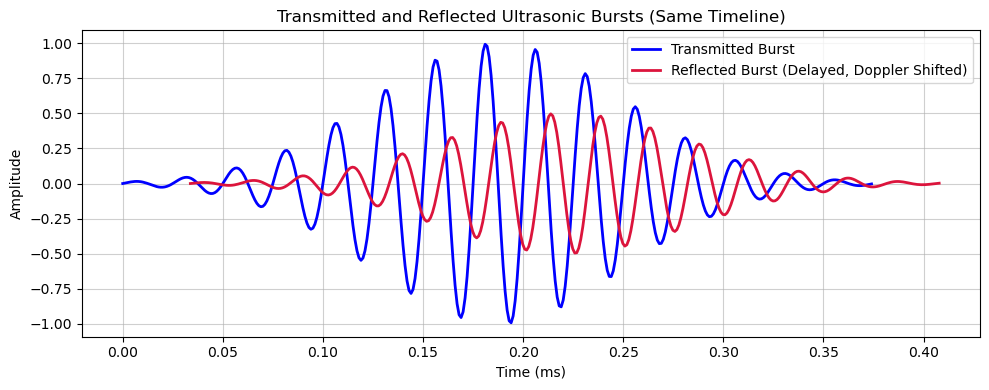

In [4]:
# Create combined timeline to place both original and reflected bursts
plt.figure(figsize=(10,4))
plt.plot(t_pulse * 1e3, burst, label='Transmitted Burst', color='blue', linewidth=2)
plt.plot(t_reflected * 1e3, reflected_burst, label='Reflected Burst (Delayed, Doppler Shifted)', color='crimson', linewidth=2)
plt.title("Transmitted and Reflected Ultrasonic Bursts (Same Timeline)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()

Estimated reflected signal frequency (Hz): 40000.0


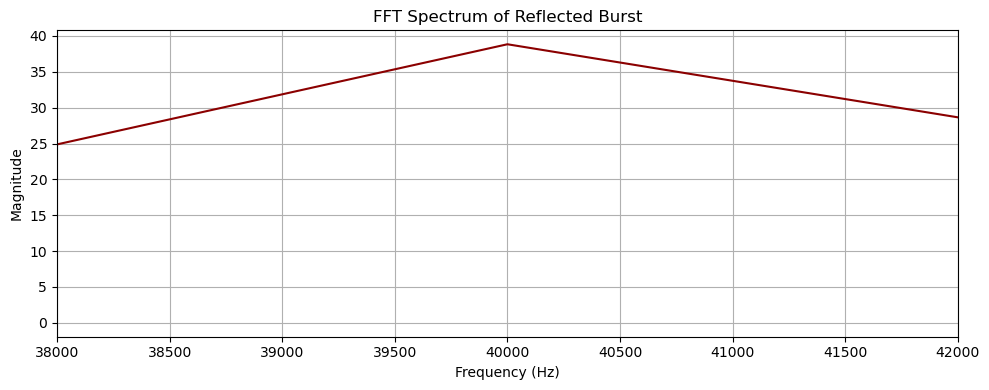

In [5]:
# Find the Frequency of the reflected signal

# 'reflected_signal_total' contains all reflected bursts (your Rx signal)
N = len(reflected_burst)
freqs = rfftfreq(N, d=1/sampling_rate)
reflected_fft = np.abs(rfft(reflected_burst))

# Find the highest peak in the carrier frequency range, e.g. ±2kHz around 40kHz
search_band = (frequency - 2000, frequency + 2000)
low_idx = np.searchsorted(freqs, search_band[0])
high_idx = np.searchsorted(freqs, search_band[1])
peak_idx = np.argmax(reflected_fft[low_idx:high_idx]) + low_idx
peak_frequency = freqs[peak_idx]
print("Estimated reflected signal frequency (Hz):", peak_frequency)

plt.figure(figsize=(10,4))
plt.plot(freqs, reflected_fft, color='darkred')
plt.title("FFT Spectrum of Reflected Burst")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(frequency - 2000, frequency + 2000)
plt.grid(True)
plt.tight_layout()
plt.show()

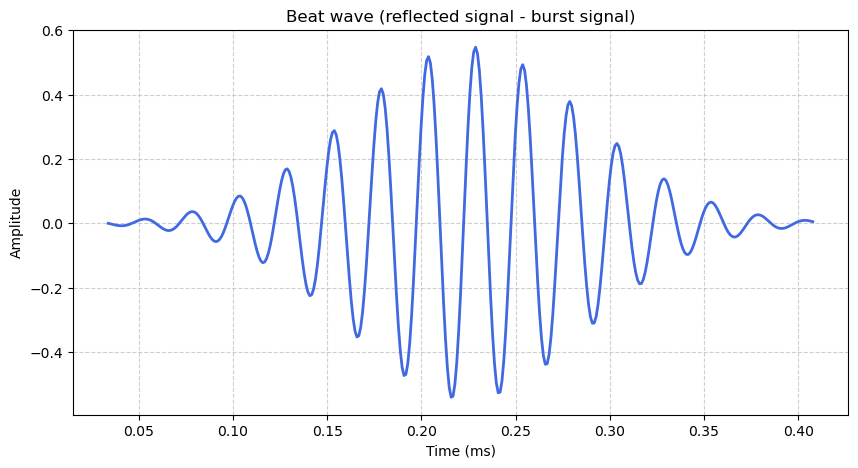

In [6]:
# Use the burst and reflected signal to get the beat frequency (Received signal - burst sent signal)
beat_wave =  reflected_burst - burst

# Plot the beat_wave signal
plt.figure(figsize=(10, 5))
plt.plot(t_reflected * 1e3, beat_wave, color='royalblue', linewidth=2)
plt.title("Beat wave (reflected signal - burst signal)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# More than one Bursts to simulate the beat frequency


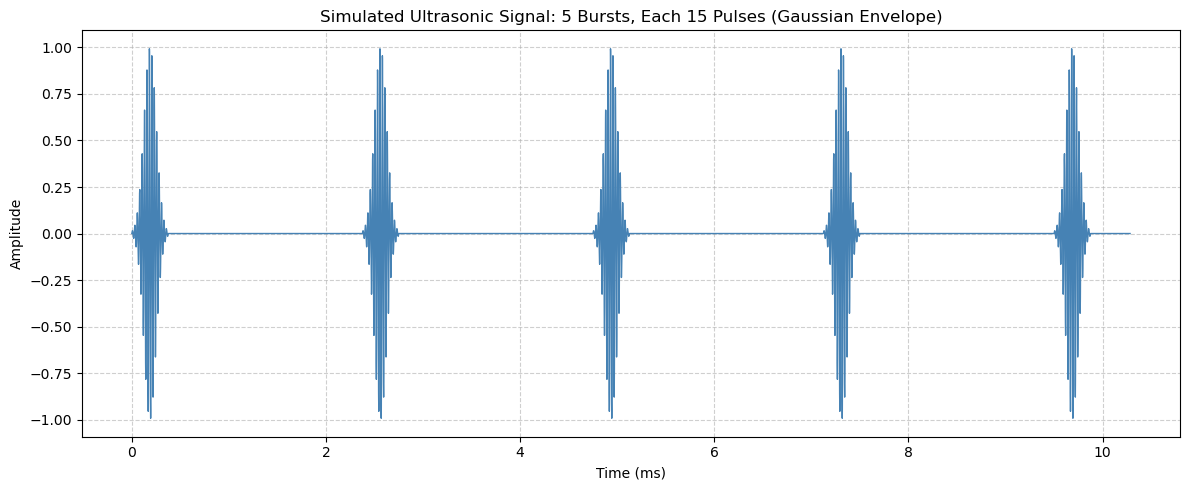

In [7]:
# Single burst duration
burst_duration = num_pulses / frequency

# Total signal duration calculation
total_duration = num_bursts * burst_duration + (num_bursts-1) * burst_spacing + time_delay + burst_duration

# Main time axis
t_total = np.arange(0, total_duration, 1 / sampling_rate)
signal_total = np.zeros_like(t_total)

for n in range(num_bursts):
    # Burst start/end sample indices
    burst_start = int((burst_duration + burst_spacing) * n * sampling_rate)
    burst_end   = burst_start + int(burst_duration * sampling_rate)
    
    # Time axis for this burst
    t_burst = t_total[burst_start:burst_end] - t_total[burst_start]
    
    # Generate burst
    signal = np.sin(2 * np.pi * frequency * t_burst)
    center = len(t_burst) / 2
    sigma = len(t_burst) / 6
    envelope = np.exp(-0.5 * ((np.arange(len(t_burst)) - center) / sigma) ** 2)
    burst_wave = signal * envelope

    # Place burst into main signal
    signal_total[burst_start:burst_end] = burst_wave

# Plot the multi-burst signal
plt.figure(figsize=(12, 5))
plt.plot(t_total * 1e3, signal_total, color='steelblue', linewidth=1)
plt.title(f"Simulated Ultrasonic Signal: {num_bursts} Bursts, Each {num_pulses} Pulses (Gaussian Envelope)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

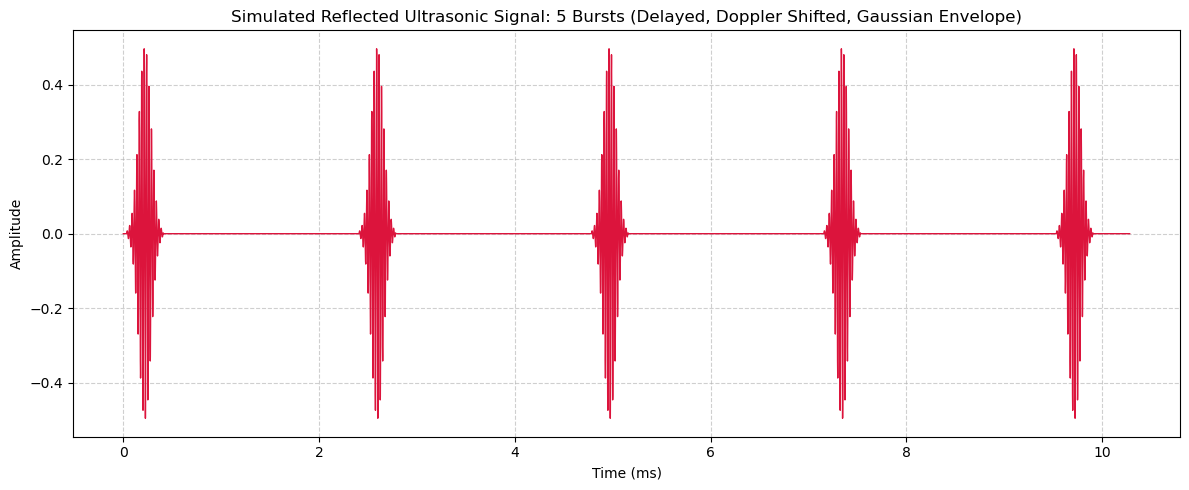

In [8]:
# Calculate the time delay for the echo (two-way travel time)
time_delay = 2 * distance / speed_of_sound

# Doppler-shifted frequency calculation for reflected wave
doppler_frequency = frequency * (speed_of_sound + velocity_reflector) / speed_of_sound

# Prepare reflected signal
reflected_signal_total = np.zeros_like(t_total)

for n in range(num_bursts):
    # Burst start/end sample indices for transmitted burst
    burst_start = int((burst_duration + burst_spacing) * n * sampling_rate)
    burst_end   = burst_start + int(burst_duration * sampling_rate)
    # Burst start sample for reflected burst (delayed)
    reflected_start = burst_start + int(time_delay * sampling_rate)
    reflected_end   = reflected_start + int(burst_duration * sampling_rate)
    
    if reflected_end > len(t_total):
        # Skip if reflected burst would extend beyond signal duration
        continue
    
    # Time axis for this reflected burst
    t_reflected_burst = t_total[reflected_start:reflected_end] - t_total[reflected_start]
    
    # Generate reflected burst signal
    reflected_signal = np.sin(2 * np.pi * doppler_frequency * t_reflected_burst)
    center = len(t_reflected_burst) / 2
    sigma = len(t_reflected_burst) / 6
    reflected_envelope = np.exp(-0.5 * ((np.arange(len(t_reflected_burst)) - center) / sigma) ** 2)
    reflected_burst_wave = attenuation_factor * reflected_signal * reflected_envelope

    # Place reflected burst into main reflected signal
    reflected_signal_total[reflected_start:reflected_end] = reflected_burst_wave

# Plot the multi-burst reflected signal
plt.figure(figsize=(12, 5))
plt.plot(t_total * 1e3, reflected_signal_total, color='crimson', linewidth=1)
plt.title(f"Simulated Reflected Ultrasonic Signal: {num_bursts} Bursts (Delayed, Doppler Shifted, Gaussian Envelope)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

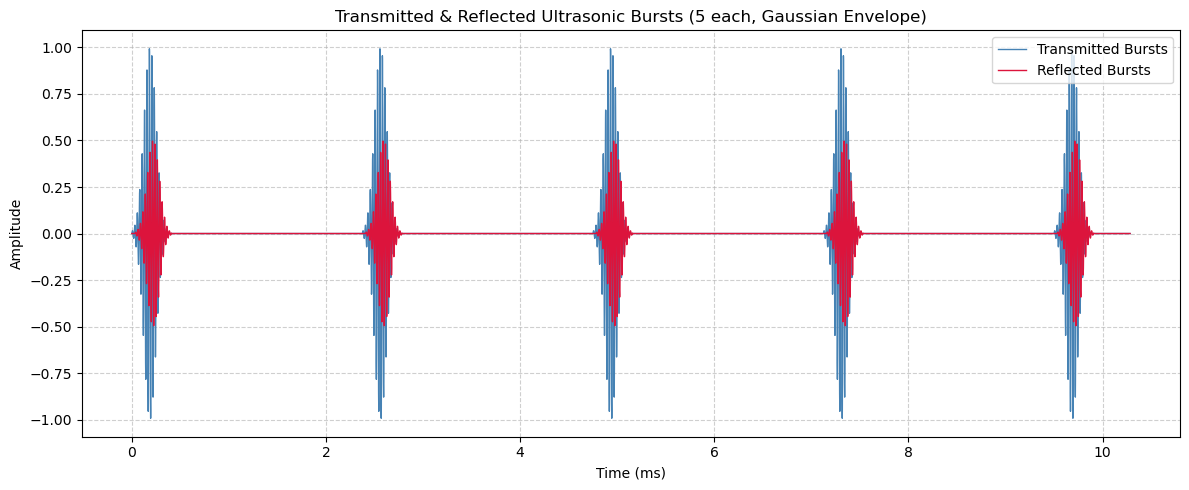

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(t_total * 1e3, signal_total, label='Transmitted Bursts', color='steelblue', linewidth=1)
plt.plot(t_total * 1e3, reflected_signal_total, label='Reflected Bursts', color='crimson', linewidth=1)
plt.title(f"Transmitted & Reflected Ultrasonic Bursts ({num_bursts} each, Gaussian Envelope)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Reflected signal peak frequency (Hz): 40840.140023337226


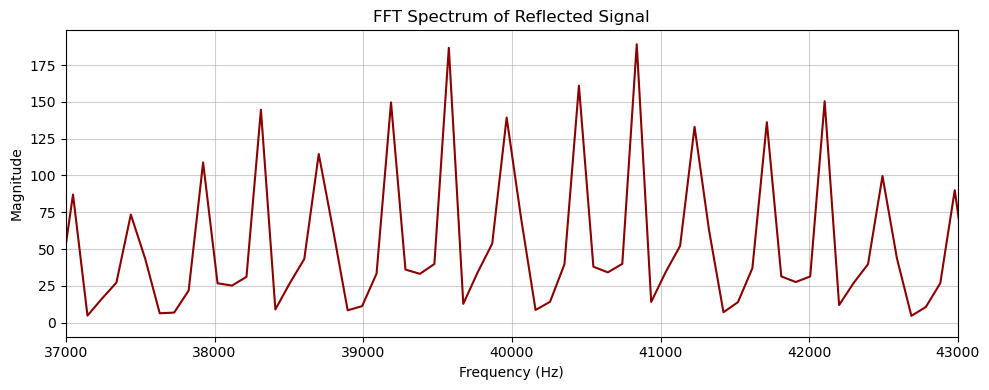

In [10]:
# Find the Frequency of the reflected signal

# 'reflected_signal_total' contains all reflected bursts (your Rx signal)
N = len(reflected_signal_total)
freqs = rfftfreq(N, d=1 / sampling_rate)
reflected_fft = np.abs(rfft(reflected_signal_total))

# Find the highest peak in the carrier frequency range, e.g. ±2kHz around 40kHz
freq_band = (frequency - 2000, frequency + 2000)
low_idx = np.searchsorted(freqs, freq_band[0])
high_idx = np.searchsorted(freqs, freq_band[1])
peak_idx = np.argmax(reflected_fft[low_idx:high_idx]) + low_idx
peak_frequency = freqs[peak_idx]
print("Reflected signal peak frequency (Hz):", peak_frequency)

# Optional: Plot FFT for visual
plt.figure(figsize=(10,4))
plt.plot(freqs, reflected_fft, color='darkred')
plt.title("FFT Spectrum of Reflected Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(frequency - 3000, frequency + 3000)
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()

# Compute the beat wave and its frequency

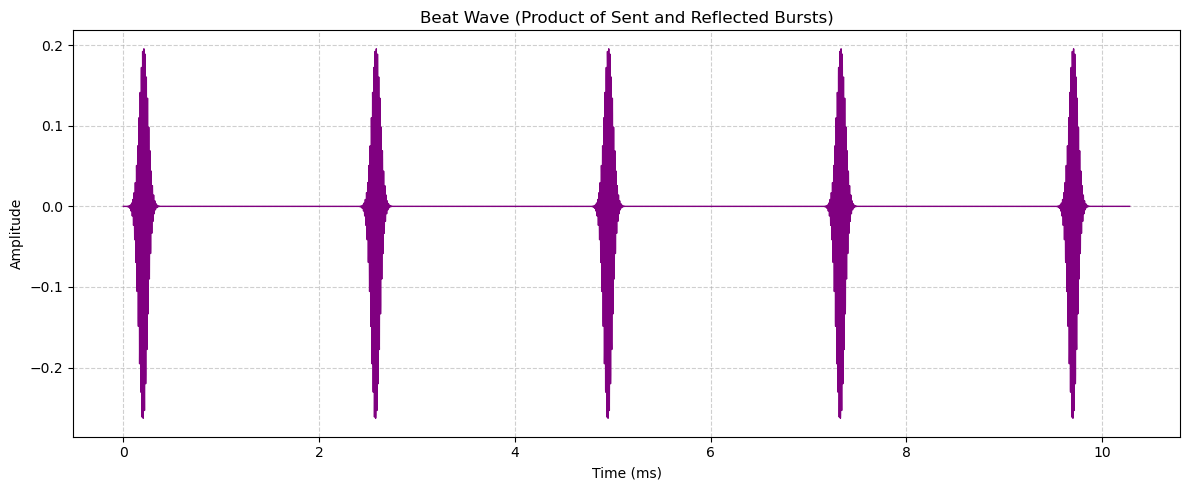

In [11]:
# Multiply the sent burst and the reflected bursts to form the beat signal
product_signal =  signal_total * reflected_signal_total

# Plot the resulting beat (mixed) signal
plt.figure(figsize=(12, 5))
plt.plot(t_total * 1e3, product_signal, color='purple', linewidth=1)
plt.title("Beat Wave (Product of Sent and Reflected Bursts)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Analysis of beat frequency

All detected FFT peaks (beat frequency range):
Frequency: 389.0 Hz, Magnitude: 14.98
Frequency: 875.1 Hz, Magnitude: 14.51
Frequency: 1264.1 Hz, Magnitude: 18.30
Frequency: 1653.1 Hz, Magnitude: 14.10


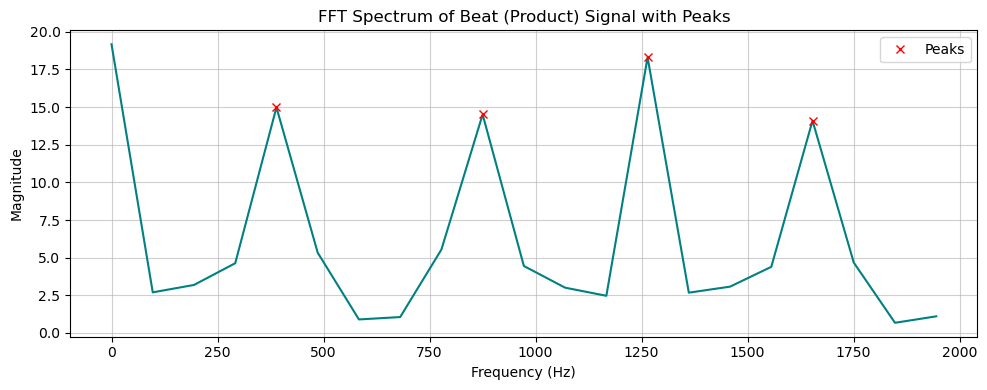

In [14]:
from scipy.signal import find_peaks

# Restrict FFT to beat frequency (audio) range
max_beat_freq = 2000
max_index = np.searchsorted(freqs, max_beat_freq)
fft_segment = product_signal_fft[:max_index]
freq_segment = freqs[:max_index]

# Find all peaks in the FFT segment
peaks, properties = find_peaks(fft_segment, height=0)  # height=0 returns all local maxima

# Print and plot all detected peaks
peak_freqs = freq_segment[peaks]
peak_mags = fft_segment[peaks]
print("All detected FFT peaks (beat frequency range):")
for f, m in zip(peak_freqs, peak_mags):
    print(f"Frequency: {f:.1f} Hz, Magnitude: {m:.2f}")

plt.figure(figsize=(10,4))
plt.plot(freq_segment, fft_segment, color='teal')
plt.plot(peak_freqs, peak_mags, "rx", label="Peaks")
plt.title("FFT Spectrum of Beat (Product) Signal with Peaks")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()